In [1]:
import pandas as pd
import numpy as np
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [2]:
train = pd.read_csv("../data/train.csv")
test = pd.read_csv("../data/test.csv")

In [3]:
target_col = "Survived"
id_col = "PassengerId"

1️⃣ Title 추출 + 유사 타이틀 통합 + Rare 묶기

In [4]:
for df in [train, test]:
    # Name에서 Title (Mr, Miss, Mrs, etc.) 추출
    df["Title"] = df["Name"].str.extract(r" ([A-Za-z]+)\.", expand=False)
    
    # 의미상 같은 타이틀 통합
    df["Title"] = df["Title"].replace({
        "Mlle": "Miss",
        "Ms": "Miss",
        "Mme": "Mrs"
    })

In [5]:
print("=== Train Title value counts ===")
print(train["Title"].value_counts())
print("\n=== Test Title value counts ===")
print(test["Title"].value_counts())

=== Train Title value counts ===
Title
Mr          517
Miss        185
Mrs         126
Master       40
Dr            7
Rev           6
Major         2
Col           2
Don           1
Lady          1
Sir           1
Capt          1
Countess      1
Jonkheer      1
Name: count, dtype: int64

=== Test Title value counts ===
Title
Mr        240
Miss       79
Mrs        72
Master     21
Col         2
Rev         2
Dr          1
Dona        1
Name: count, dtype: int64


In [6]:
title_counts = train["Title"].value_counts()
rare_titles = title_counts[title_counts < 10].index  # 10명 미만은 Rare로

rare_titles

Index(['Dr', 'Rev', 'Major', 'Col', 'Don', 'Lady', 'Sir', 'Capt', 'Countess',
       'Jonkheer'],
      dtype='object', name='Title')

In [7]:
for df in [train, test]:
    df["Title"] = df["Title"].replace(rare_titles, "Rare")

print(train["Title"].value_counts())

Title
Mr        517
Miss      185
Mrs       126
Master     40
Rare       23
Name: count, dtype: int64


2️⃣ Fare 결측치 + 로그 변환

In [8]:
train["Fare"].fillna(train["Fare"].median(), inplace=True)
test["Fare"].fillna(test["Fare"].median(), inplace=True)

train["Fare"] = np.log1p(train["Fare"])
test["Fare"]  = np.log1p(test["Fare"])

/var/folders/2b/ygjk4ynx02nfg35yptspnpxw0000gn/T/ipykernel_79324/1761839558.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train["Fare"].fillna(train["Fare"].median(), inplace=True)
/var/folders/2b/ygjk4ynx02nfg35yptspnpxw0000gn/T/ipykernel_79324/1761839558.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting v

<Axes: xlabel='Fare', ylabel='Count'>

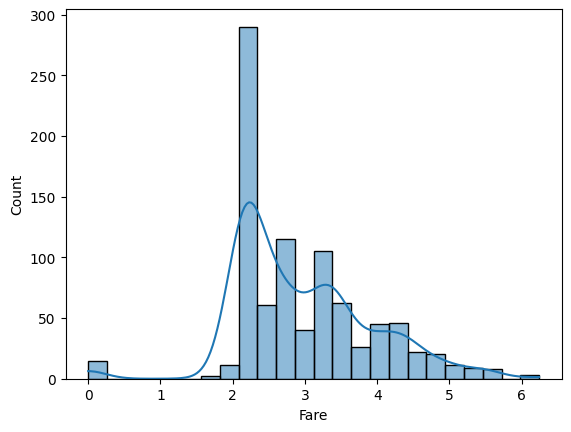

In [9]:
sns.histplot(train["Fare"], kde=True)

3️⃣ Age 결측치 → Title 기반으로 채우기

In [10]:
age_median_by_title = train.groupby("Title")["Age"].median()

def fill_age(row):
    if pd.isna(row["Age"]):
        return age_median_by_title[row["Title"]]
    return row["Age"]

train["Age"] = train.apply(fill_age, axis=1)
test["Age"]  = test.apply(fill_age, axis=1)

In [11]:
train["Age"].isna().sum(), test["Age"].isna().sum()

(np.int64(0), np.int64(0))

Familiy size 전처리

In [12]:
for df in [train, test]:
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1

In [13]:
for df in [train, test]:
    df['IsAlone'] = (df['FamilySize'] == 1).astype(int)

In [14]:
train = train.drop(columns=["SibSp", "Parch"])
test  = test.drop(columns=["SibSp", "Parch"])

4️⃣ Embarked 결측치 처리

In [15]:
# Embarked 값 분포 + 결측치까지 같이 보기
print("=== Embarked value counts (train) ===")
print(train["Embarked"].value_counts(dropna=False))
print("Missing in train:", train["Embarked"].isna().sum())

print("\n=== Embarked value counts (test) ===")
print(test["Embarked"].value_counts(dropna=False))
print("Missing in test:", test["Embarked"].isna().sum())

=== Embarked value counts (train) ===
Embarked
S      644
C      168
Q       77
NaN      2
Name: count, dtype: int64
Missing in train: 2

=== Embarked value counts (test) ===
Embarked
S    270
C    102
Q     46
Name: count, dtype: int64
Missing in test: 0


In [16]:
# train에서 최빈값 구해서 train/test 둘 다 채우기
embarked_mode = train["Embarked"].mode()[0]
print("Embarked mode:", embarked_mode)

for df in [train, test]:
    df["Embarked"] = df["Embarked"].fillna(embarked_mode)

# 잘 채워졌는지 다시 확인
print("After fillna -> train missing:", train["Embarked"].isna().sum())
print("After fillna -> test missing :", test["Embarked"].isna().sum())

Embarked mode: S
After fillna -> train missing: 0
After fillna -> test missing : 0


5️⃣ 불필요 컬럼 삭제

In [17]:
drop_cols = ["Name", "Ticket", "Cabin"]

train = train.drop(columns=drop_cols)
test  = test.drop(columns=drop_cols)

6️⃣ 범주형 인코딩 (Sex, Pclass, Title만!)

In [18]:
categorical_cols = ["Sex", "Pclass", "Title", "Embarked"]

# 1) 타깃 분리
y_train = train[target_col]
train_features = train.drop(columns=[target_col])

# 2) Embarked까지 포함한 categorical columns
categorical_cols = ["Sex", "Pclass", "Title", "Embarked"]

# 3) train + test 합쳐서 인코딩 (열 맞추기 위함)
combined = pd.concat([train_features, test], axis=0)

combined_encoded = pd.get_dummies(
    combined,
    columns=categorical_cols,
    drop_first=True
)

# 4) 다시 분리
X_train = combined_encoded.iloc[:len(train), :].copy()
X_test  = combined_encoded.iloc[len(train):, :].copy()

In [19]:
X_train.head()

,PassengerId,Age,Fare,FamilySize,IsAlone,Sex_male,Pclass_2,Pclass_3,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,Embarked_Q,Embarked_S
0,1,22.0,2.110213,2,0,True,False,True,False,False,True,False,False,False,True
1,2,38.0,4.280593,2,0,False,False,False,False,False,False,True,False,False,False
2,3,26.0,2.188856,1,1,False,False,True,False,True,False,False,False,False,True
3,4,35.0,3.990834,2,0,False,False,False,False,False,False,True,False,False,True
4,5,35.0,2.202765,1,1,True,False,True,False,False,True,False,False,False,True


7 스케일링 (Age, Fare)

In [20]:
from sklearn.preprocessing import StandardScaler

scale_cols = ["Age", "Fare", "FamilySize"]
scaler = StandardScaler()

X_train[scale_cols] = scaler.fit_transform(X_train[scale_cols])
X_test[scale_cols]  = scaler.transform(X_test[scale_cols])

저장

In [25]:
import pickle

with open("../data/X_train.pkl", "wb") as f:
    pickle.dump(X_train, f)

with open("../data/y_train.pkl", "wb") as f:
    pickle.dump(y_train, f)

with open("../data/X_test.pkl", "wb") as f:
    pickle.dump(X_test, f)

In [ ]:
X_train.to_csv("../data/X_train_processed.csv", index=False)
y_train.to_csv("../data/y_train.csv", index=False)
X_test.to_csv("../data/X_test_processed.csv", index=False)

확인

In [ ]:
print("X_train shape:", X_train.shape)
print("X_test shape :", X_test.shape)

X_train shape: (891, 15)
X_test shape : (418, 15)


In [ ]:
print("Missing values in X_train:")
print(X_train.isna().sum().sum())

print("Missing values in X_test:")
print(X_test.isna().sum().sum())

Missing values in X_train:
0
Missing values in X_test:
0
